<img src="MatchBrand%20symbol.png" alt="MatchBrand Symbol">


# **Job Dataset Preprocessing**

# A. Load Libraries


In [67]:
# Install pip packages if not done in alphabetical order to avoid duplicates

#!pip install deep_translator
#!pip install ipywidgets
#!pip install nltk
#!pip install openpyxl
#!pip install pyLDAvis
#!pip install spacy
#!pip install transformers
#!pip install wordcloud
#!pip install ydata-profiling


In [68]:
# Import packages in alphabetical order to avoid duplicates
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import re
import spacy
import string
import torch

# Import packages in alphabetical order to avoid duplicates
from deep_translator import GoogleTranslator
from gensim.models import Word2Vec
from ipywidgets import HTML, Button, widgets
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from transformers import BertModel, BertTokenizer
from wordcloud import WordCloud
from ydata_profiling import ProfileReport


# B. Read in the Data

This job dataset has been provided by MatchBrand and showcases a diverse array of current job offerings from EDEKA. To enrich the dataset and broaden our analysis, we have incorporated relevant job listings from Stepstone, a prominent job search platform.

In [69]:
# Read in job posting dataset
df = pd.read_excel('Datasets/dataset_hwr_job_posting.xlsx')

# C. Exploratory Data Analysis - Profile Report

Initially, we embarked on an exploratory data analysis to gain comprehensive insights into our dataset. To facilitate this process efficiently, we leveraged the ydata Profile Report, a tool known for its appealing layout and rapid output generation. This report allowed us to quickly assess key statistical measures, visualize data distributions, and identify potential data anomalies or missing values.

During the exploratory phase, we delved into various aspects of the dataset, such as data distribution, summary statistics, correlation analyses, and data quality assessments. This enabled us to develop a deep understanding of the dataset's characteristics, providing us with a solid foundation for subsequent data cleaning and analysis tasks.

The report is saved as a html file in the Datasets folder to save time and computional resources. 

In [70]:
''' Uncomment if new report file is needed	
# Define output directory
output_directory = "Datasets/"

# Generate a report for the job dataset
profile = ProfileReport(df, title="Pandas Profiling Report Job Dataset")

# Save the report as HTML in the 'Datasets' directory
profile.to_file(output_file=output_directory + "job_data_profiling_report.html")
'''

' Uncomment if new report file is needed\t\n# Define output directory\noutput_directory = "Datasets/"\n\n# Generate a report for the job dataset\nprofile = ProfileReport(df, title="Pandas Profiling Report Job Dataset")\n\n# Save the report as HTML in the \'Datasets\' directory\nprofile.to_file(output_file=output_directory + "job_data_profiling_report.html")\n'

# D. Data Cleaning


Throughout our exploration of the dataset and our pursuit of effectively matching job offerings to Instagram profiles, we recognized the critical importance of conducting comprehensive data cleaning. Our goal was to eliminate any noise and elevate the quality of the dataset, making it ready for in-depth analysis. With this in mind, we executed a series of personalized cleaning steps, each tailored to enhance the relevance and accuracy of the data.

In the subsequent sections, we will walk through the specific cleaning actions we took and the reasons behind each decision.  

### **Step 1: Translate Data to English**

To facilitate matching job offerings to Instagram profiles, it's essential to have all data in a unified language, and English is the primary language in the Instagram dataset. To achieve this, we utilized the Google Translator API and set the source language to German, as the job dataset is in German. This language translation step helps improve the accuracy of matching and ensures that the two datasets can be efficiently compared.

Additionally, due to the character limit of the Google Translator API (5000 characters), we implemented a loop to translate the data in smaller batches. This approach ensures that the entire dataset is translated accurately and efficiently, overcoming any limitations imposed by the API.

### **Step 2: Define Data Cleaning Function `data_clean`**

To prepare the text data for further analysis, we created a data cleaning function called data_clean. This function performs several essential cleaning actions on the 'caption' column:

- All text is converted to lowercase to ensure case-insensitivity during matching and analysis.
- Additional patterns like '-' were removed to standardize the text and avoid variations caused by such characters.
- Numerals and punctuation were eliminated to focus solely on the textual content without the distractions of numbers and special characters.
- Multiple whitespaces were replaced with single whitespaces to normalize the text and improve consistency.
- We removed additional words (in this case 'mfd') to reduce noise. 
- In the initial exploration of the data, we identified certain columns, namely 'Career level', 'Other information', 'Location', 'Company' and 'Start date,' that were not relevant to our specific task of matching job offerings to Instagram profiles. Since these columns didn't provide any valuable information for our analysis, we decided to exclude them from the dataset to streamline the matching process and reduce unnecessary noise.


### **Step 3: Merge Columns**

To simplify the vectorization process for calculating cosine similarity in later steps, we merged all relevant columns into a single 'Merged' column. By consolidating the textual content into one column, we create a coherent and compact representation of the job offerings, making the analysis more efficient.

### **Step 4: Remove English Stopwords**

After merging the columns, we proceeded to remove common English stopwords. The English stopwords (e.g., "the," "is," "and") do not contribute significantly to the meaning of the text and can introduce noise. Eliminating these words further refines the dataset, allowing us to focus on the more meaningful terms during matching and analysis.

### **Step 5: Remove Short Words**

To eliminate potential noise caused by short, less informative words, we removed words with fewer than three characters from the dataset. Short words are often common and provide limited semantic value in the context of our analysis. By filtering out such words, we enhance the quality of the text data, leading to more meaningful matching results.

### **Step 6: Drop Null Values**

To ensure the cleanliness of the dataset, we performed this step of dropping any remaining null values. Null values can arise due to missing or incomplete data and may hinder accurate matching and analysis. By removing these instances, we ensure that our dataset is complete and ready for further processing.

### **Step 7: Save as Pickle File**

To avoid the need to rerun the data cleaning process in the future, we saved the cleaned job dataset as a pickle file. This file format preserves the data structure, making it easy to reload the cleaned dataset without repeating the cleaning steps. Saving the dataset as a pickle file also saves time and computational resources, contributing to a more efficient workflow.


## **Step 1: Translate Data to English**

In [71]:
# Defining a function to translate text to English
def translate_text(text):
    try:
        if isinstance(text, str):
            if len(text) <= 5000:
                return translator.translate(text)
            else:
                # Split the text into chunks of 5000 characters or less
                chunks = wrap(text, 5000)
                translated_chunks = []
                # Translate each chunk individually
                for chunk in chunks:
                    translated_chunks.append(translator.translate(chunk))
                # Reassemble the translated chunks into a single string
                return ' '.join(translated_chunks)
    except:
        pass
    return text

translator = GoogleTranslator(source='auto', target='english')

# Translate every valid cell in the DataFrame
df_translated = df.applymap(translate_text)


## **Step 2: Define Data Cleaning Function `data_clean`**

In [72]:
# Defining a data cleaning function called data_clean

def data_clean(df):
 
    # Lowercase the columns
    df['Title'] = df['Title'].str.lower()
    df['Job description'] = df['Job description'].str.lower()
    df['Requirements'] = df['Requirements'].str.lower()

    # Remove additional patterns
    df['Title'] = df['Title'].replace(['\n', ':in', '(mwd)', '(fmdiv.)', '“', '–', '„', '’', 'z b '], '', regex=True)

    # Remove numerals and punctuation
    punctuation = string.punctuation + string.digits
    df['Title'] = df['Title'].apply(lambda x: re.sub(r'[' + punctuation + ']', '', x))
    df['Job description'] = df['Job description'].apply(lambda x: re.sub(r'[' + punctuation + ']', '', x))
    df['Requirements'] = df['Requirements'].apply(lambda x: re.sub(r'[' + punctuation + ']', '', x))

    # Replace multiple whitespaces with a single whitespace
    df['Title'] = df['Title'].replace('\\s+', ' ', regex=True)
    df['Job description'] = df['Job description'].replace('\\s+', ' ', regex=True)
    df['Requirements'] = df['Requirements'].replace('\\s+', ' ', regex=True)

    # Remove additional words
    additional_words = ['mfd']  
    df['Title'] = df['Title'].apply(lambda x: ' '.join(word for word in x.lower().split() if word not in additional_words))

    # Drop irrelevant columns
    df.drop(['Career level', 'Other information', 'Start date', 'Location', 'Company'], axis=1, inplace=True)

    return df


In [73]:
# Apply data_clean function to df
df_cleaned = data_clean(df_translated)

## **Step 3: Merge Columns**

In [74]:
# Merge all columns into one called 'Merged'

df_cleaned['Merged'] = df_cleaned['Title'] + ' ' +  df_cleaned['Job description'] + ' ' + df_cleaned['Requirements']


## **Step 4: Remove English Stopwords**

In [75]:
# Remove English stopwords from the translated dataframe

stopwords_english = set(stopwords.words("english"))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords_english]
    return " ".join(filtered_tokens)

# Apply the function to the dataframe
df_cleaned['Merged'] = df_cleaned['Merged'].apply(remove_stopwords)

# Save the dataframe as df_english_without_stopwords
df_english_without_stopwords = df_cleaned


## **Step 5: Remove Short Words**


In [76]:
# Delete words with less than three characters
df_english_without_stopwords['Merged'] = df_english_without_stopwords['Merged'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

## **Step 6: Drop Null Values**

In [77]:
# Drop null values
df_english_without_stopwords['Merged'].replace('', np.nan, inplace=True)
df_english_without_stopwords = df_english_without_stopwords.dropna(subset=['Merged'])


## **Step 7: Save as Pickle File**

In [78]:
# Save DataFrame as pickle file
with open('Datasets/df_translated_job.pkl', 'wb') as f:
    pickle.dump(df_english_without_stopwords, f)

# E. Data Review with Wordcloud


After completing the data cleaning process, we utilized the Wordcloud visualization to explore potential topics within our refined Job Dataset. The Wordcloud offered an insightful and visually engaging representation of the most frequent words found in the merged columns of the Job offerings. This analysis provided us with a deeper understanding of the content preferences and interests of the job offerings, helping us uncover relevant topics and trends that could be further explored in our matching and analysis tasks.


c:\Users\loeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


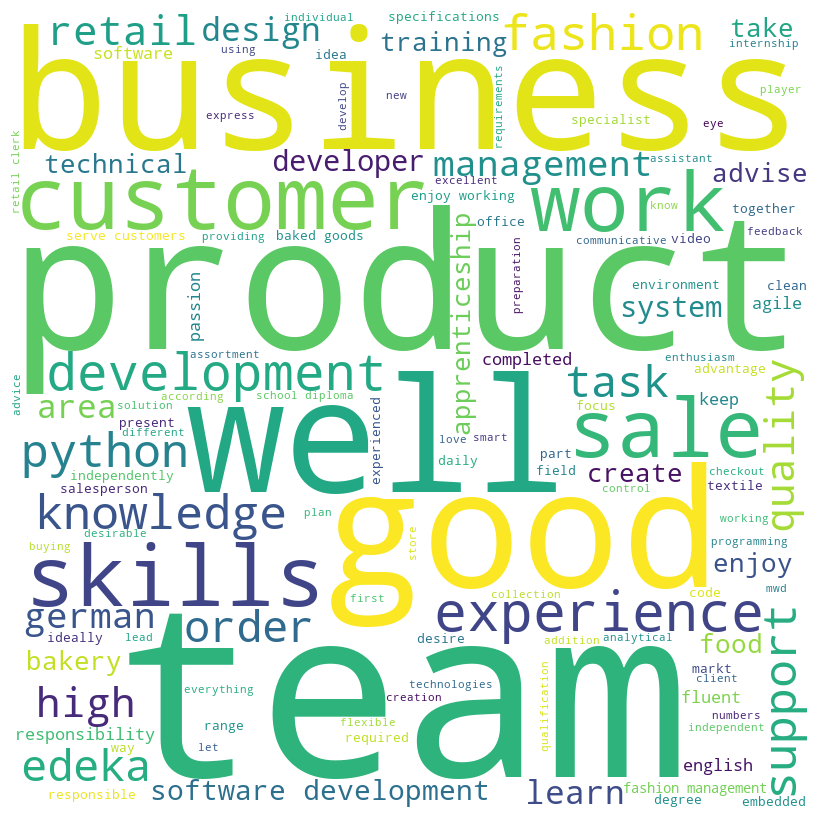

In [79]:
# Concatenate all text data in your DataFrame. For example, let's assume you're interested in a column named 'caption'
text = ' '.join(df_english_without_stopwords['Merged'])

# Generate the Wordcloud
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = None, 
                      min_font_size = 10).generate(text) 

# Plot the Wordcloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 